In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

In [ ]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [ ]:
for category in range(4):
    images = [img_to_array(load_img(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}/{file}', color_mode='grayscale', target_size=(360, 480))) for file in os.listdir(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}')]

    labels = [category] * len(images)

    train_images_category, test_images_category, train_labels_category, test_labels_category = train_test_split(images, labels, test_size=0.2)

    train_images.extend(train_images_category)
    test_images.extend(test_images_category)
    train_labels.extend(train_labels_category)
    test_labels.extend(test_labels_category)

In [ ]:
x_train = np.array(train_images)
x_test = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [ ]:
print(x_train.shape[1])

360


**VGG**

In [ ]:
start_time = time.time()


In [ ]:
from tensorflow.keras.applications import VGG19


In [ ]:
x_train = np.array([np.repeat(img, 3, axis=-1) for img in x_train])
x_test = np.array([np.repeat(img, 3, axis=-1) for img in x_test])

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))


80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
vgg_model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [ ]:
vgg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history3 = vgg_model.fit(x_train, train_labels, epochs=100, validation_data=(x_test, test_labels))


Epoch 1/100
24/24 [==============================] - 23s 474ms/step - loss: 3.5984 - accuracy: 0.3644 - val_loss: 0.9774 - val_accuracy: 0.5668
Epoch 2/100
24/24 [==============================] - 5s 224ms/step - loss: 0.9063 - accuracy: 0.6532 - val_loss: 0.7839 - val_accuracy: 0.7112
Epoch 3/100
24/24 [==============================] - 5s 217ms/step - loss: 0.7480 - accuracy: 0.7395 - val_loss: 0.6950 - val_accuracy: 0.7701
Epoch 4/100
24/24 [==============================] - 5s 213ms/step - loss: 0.6806 - accuracy: 0.7679 - val_loss: 0.7823 - val_accuracy: 0.6738
Epoch 5/100
24/24 [==============================] - 5s 218ms/step - loss: 0.5768 - accuracy: 0.8070 - val_loss: 0.5653 - val_accuracy: 0.7647
Epoch 6/100
24/24 [==============================] - 6s 234ms/step - loss: 0.5119 - accuracy: 0.8327 - val_loss: 0.5188 - val_accuracy: 0.7914
Epoch 7/100
24/24 [==============================] - 5s 203ms/step - loss: 0.4457 - accuracy: 0.8623 - val_loss: 0.4441 - val_accuracy: 0.861

6/6 [==============================] - 1s 159ms/step - loss: 0.0297 - accuracy: 0.9947


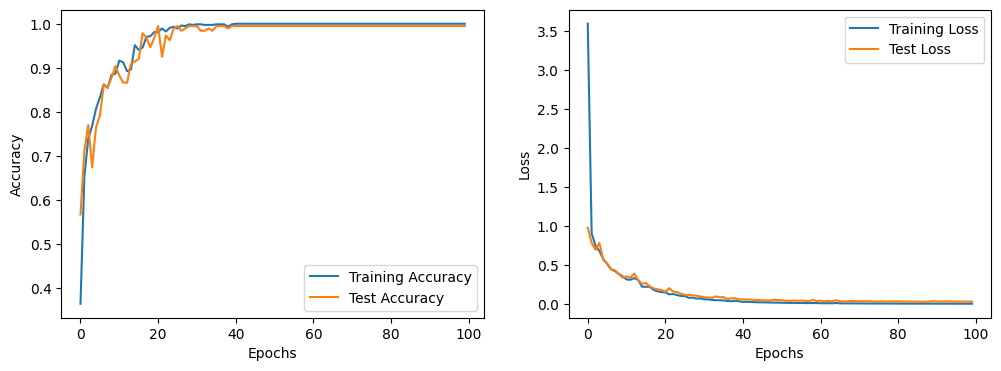

In [ ]:
test_loss, test_acc = vgg_model.evaluate(x_test, test_labels)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
predictions = vgg_model.predict(x_test)
binary_predictions = np.argmax(predictions, axis=1)
test_labels = test_labels.reshape(-1, 1)
conf_matrix = confusion_matrix(test_labels, binary_predictions)

6/6 [==============================] - 1s 154ms/step


In [ ]:
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
precision = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)


num_classes = len(conf_matrix)
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(conf_matrix) - np.sum(conf_matrix[i, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity_class = true_negatives / (true_negatives + false_positives)
    specificity.append(specificity_class)

average_specificity = np.mean(specificity)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Specificity for each class: {specificity}")
print(f"Average Specificity: {average_specificity}")

Confusion Matrix:
[[48  0  0  0]
 [ 0 46  1  0]
 [ 0  0 35  0]
 [ 0  0  0 57]]
Accuracy: 0.9947
Precision: [1.         1.         0.97222222 1.        ]
Recall: [1.        0.9787234 1.        1.       ]
F1 Score: [1.         0.98924731 0.98591549 1.        ]
Specificity for each class: [1.0, 1.0, 0.993421052631579, 1.0]
Average Specificity: 0.9983552631578947


In [ ]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time} seconds.")

Training took 581.3833780288696 seconds.
